In [1]:
# 파이썬 라이브러리
import requests
from bs4 import BeautifulSoup
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
# elem.send_keys(Keys.ENTER)
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from datetime import datetime

import pymysql # mysql 연결및 실행을 위한 모듈
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt #차트 처리를 위한 모듈
%matplotlib inline
import matplotlib.font_manager as fm
from wordcloud import WordCloud
from PIL import *

In [5]:
# 교보문고 연간 베스트셀러 100권(2018-2022 5년간) url 스크래핑

user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'

years = [i for i in range(2018,2023)]
urls = []
for year in years: # 2018-2022 5년간 반복
    urls.append([])
    for i in range(1,6): # 한 페이지 당 20권, 5페이지 반복
        # 연간 베스트렐러 목록 페이지 불러오기
        url = 'https://product.kyobobook.co.kr/bestseller/total?period=004#?page=%d&per=20&period=004&ymw=%d&bsslBksClstCode=A'%(i,year)

        options = webdriver.ChromeOptions()
        options.add_argument(user_agent)
        options.add_argument('headless') # 페이지 안 열기
        options.add_argument('window-size=1920x1080')
        options.add_argument("disable-gpu")
        # 혹은 options.add_argument("--disable-gpu")
        driver = webdriver.Chrome(options=options)
        # driver.maximize_window()
        driver.implicitly_wait(1)
        driver.get(url)
        time.sleep(0.5)

        # 각 책의 url 뽑아 urls list에 저장
        elems = driver.find_elements_by_class_name('prod_link')
        for j in range(20):
            urls[-1].append(elems[j].get_attribute('href'))

# year_urls 딕셔너리, 키는 연도, 값은 연간베스트도서 url 100개짜리 리스트
year_urls = dict(zip(years,urls))

# sql 연결 및 best_books_5years 테이블 생성
db = pymysql.connect(host='localhost', port=3306, user='root', passwd='1234', db='mywork', charset='utf8')
cursor = db.cursor()
sql = """
    CREATE TABLE IF NOT EXISTS best_books_5years(
        years SMALLINT NOT NULL,
        ranks SMALLINT NOT NULL,
        title VARCHAR(100),
        author VARCHAR(100),
        publisher VARCHAR(100),
        publishdate DATE,
        price INT,
        rate DOUBLE,
        likes VARCHAR(50),
        review_n INT,
        genre VARCHAR(50));"""
cursor.execute(sql)

# 테이블 채우기
for key, value in year_urls.items():
    # years <- key
    for i in range(len(value)):
        # ranks <- i+1
        
        headers = {'User-Agent':user_agent}
        response = requests.get(value[i], headers) # value[i]가 각 도서링크
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'lxml')
        
        title = soup.select_one('div.prod_title_area h1').text.replace(' ', '').replace('\n', '')
        # title <- title

        author = soup.select_one('div.author').text.replace(' ', '').replace('\n', '').split('저')
        # author <- author[0]

        publish_info = soup.select_one('div.prod_info_text.publish_date').text
        publish_info = publish_info.replace(' ', '').replace('\n', '').split('·')
        # publisher <- publish_info[0]
        datetime_format = "%Y년%m월%d일"
        publishdate = datetime.strptime(publish_info[1][:11], datetime_format).date()
        # publishdate <- publishdate

        price = soup.select_one('span.price span.val').text.replace('원', '').replace(',', '')
        # price <- price
        
        rating = soup.select_one('span.review_score.feel_lucky').text
        # rate <- rating

        like = soup.select_one('span.review_quotes_text').text
        # likes <- like

        cnt_review = soup.select_one('span.review_desc span.val').text
        # review_n <- cnt_review
        
        genere = soup.select('ol li.breadcrumb_item a')
        # genre <- genere[2].text
        
        sql = '''INSERT INTO best_books_5years VALUES(
        {0}, {1}, "{2}", "{3}", "{4}", "{5}", {6}, {7}, "{8}", {9}, "{10}");
        '''.format(key, i+1, title, author[0], publish_info[0], publishdate, 
                   int(price), float(rating), like, int(cnt_review), genere[2].text)
        cursor.execute(sql)
    print(year, 'done')
        
db.commit()

2020 1
2020 2
2020 3
2020 4
2020 5
2020 6
2020 7
2020 8
2020 9
2020 10
2020 11
2020 12
2020 13
2020 14
2020 15
2020 16
2020 17
2020 18
2020 19
2020 20
2020 21
2020 22
2020 23
2020 24
2020 25
2020 26
2020 27
2020 28
2020 29
2020 30
2020 31
2020 32
2020 33
2020 34
2020 35
2020 36
2020 37
2020 38
2020 39
2020 40
2020 41
2020 42
2020 43
2020 44
2020 45
2020 46
2020 47
2020 48
2020 49
2020 50
2020 51
2020 52
2020 53
2020 54
2020 55
2020 56
2020 57
2020 58
2020 59
2020 60
2020 61
2020 62
2020 63
2020 64
2020 65
2020 66
2020 67
2020 68
2020 69
2020 70
2020 71
2020 72
2020 73
2020 74
2020 75
2020 76
2020 77
2020 78
2020 79
2020 80
2020 81
2020 82
2020 83
2020 84
2020 85
2020 86
2020 87
2020 88
2020 89
2020 90
2020 91
2020 92
2020 93
2020 94
2020 95
2020 96
2020 97
2020 98
2020 99
2020 100
2021 1
2021 2
2021 3
2021 4
2021 5
2021 6
2021 7
2021 8
2021 9
2021 10
2021 11
2021 12
2021 13
2021 14
2021 15
2021 16
2021 17
2021 18
2021 19
2021 20
2021 21
2021 22
2021 23
2021 24
2021 25
2021 26
2021 27
2

<bound method Connection.close of <pymysql.connections.Connection object at 0x000002B8AE7E9A90>>

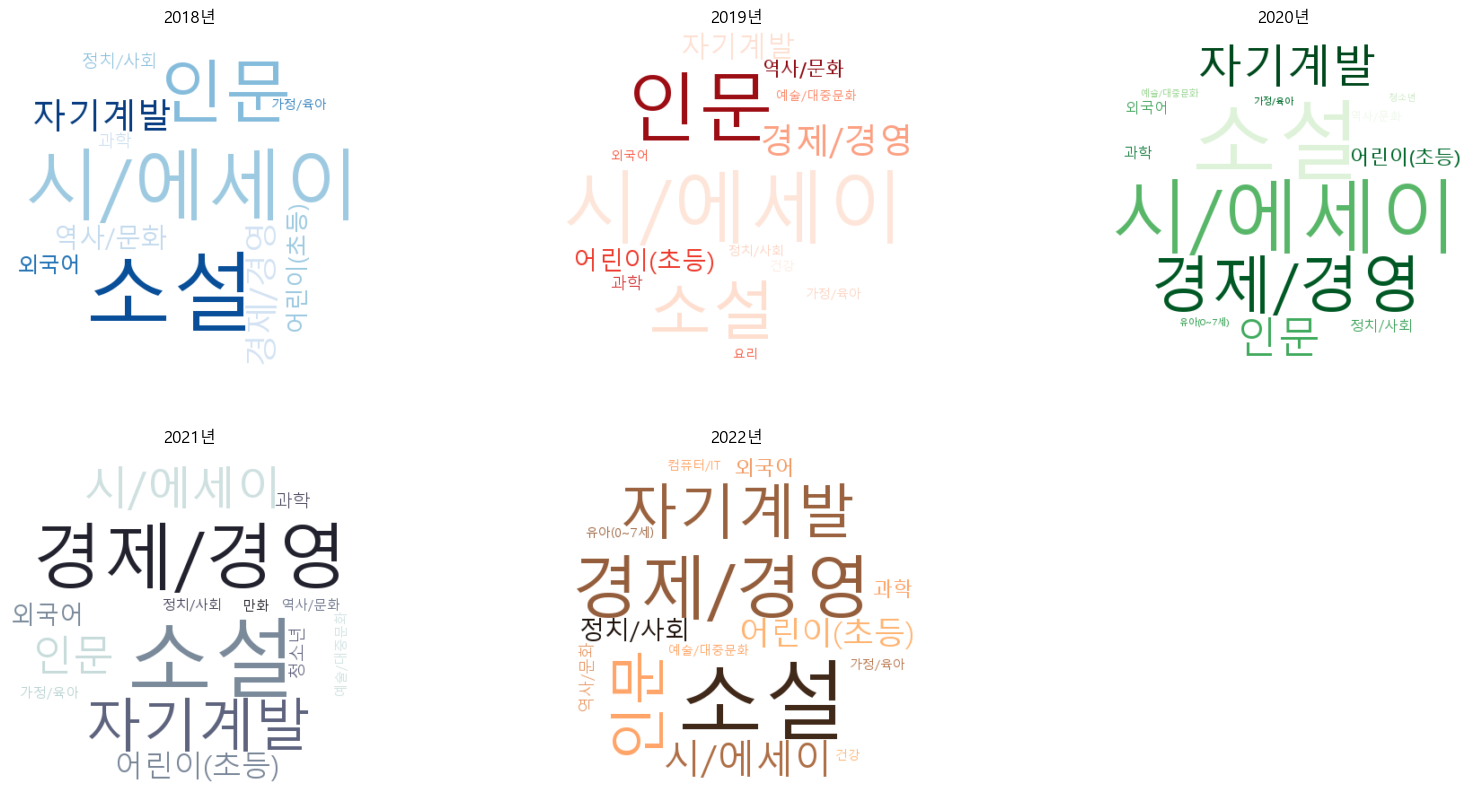

In [31]:
# 워드클라우드 연도별로 출력하기

# 한글 폰트 설정
# print([font.name for font in fm.fontManager.ttflist]) # 설치된 폰트 출력
plt.rcParams['font.family'] = 'Malgun Gothic'

# 워드 클라우드 이미지
cand_mask=np.array(Image.open('circle.jpg')) 

# 2018년부터 2022년까지
plt.figure(figsize=(20,10))
years = [i for i in range(2018,2023)]
colors = ['Blues','Reds','Greens','bone','copper']
i = 1
for year in years:  
    SQL = """SELECT genre, count(*)
    FROM best_books_5years
    WHERE years = {}
    GROUP BY genre;""".format(year) #  SQL 구문 만들기
    cursor.execute(SQL)
    res = cursor.fetchall()
    dict_res = dict((x,y)for x,y in res) # tuple -> dictionary
    
    # wrodcloud 생성
    wordcloud = WordCloud(font_path='malgun.ttf', background_color='white', 
                          colormap=colors[i-1], mask=cand_mask,).generate_from_frequencies(dict_res)
    plt.subplot(2,3,i)
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.title('{}년'.format(year))
    plt.axis('off')
    i+=1
plt.show()

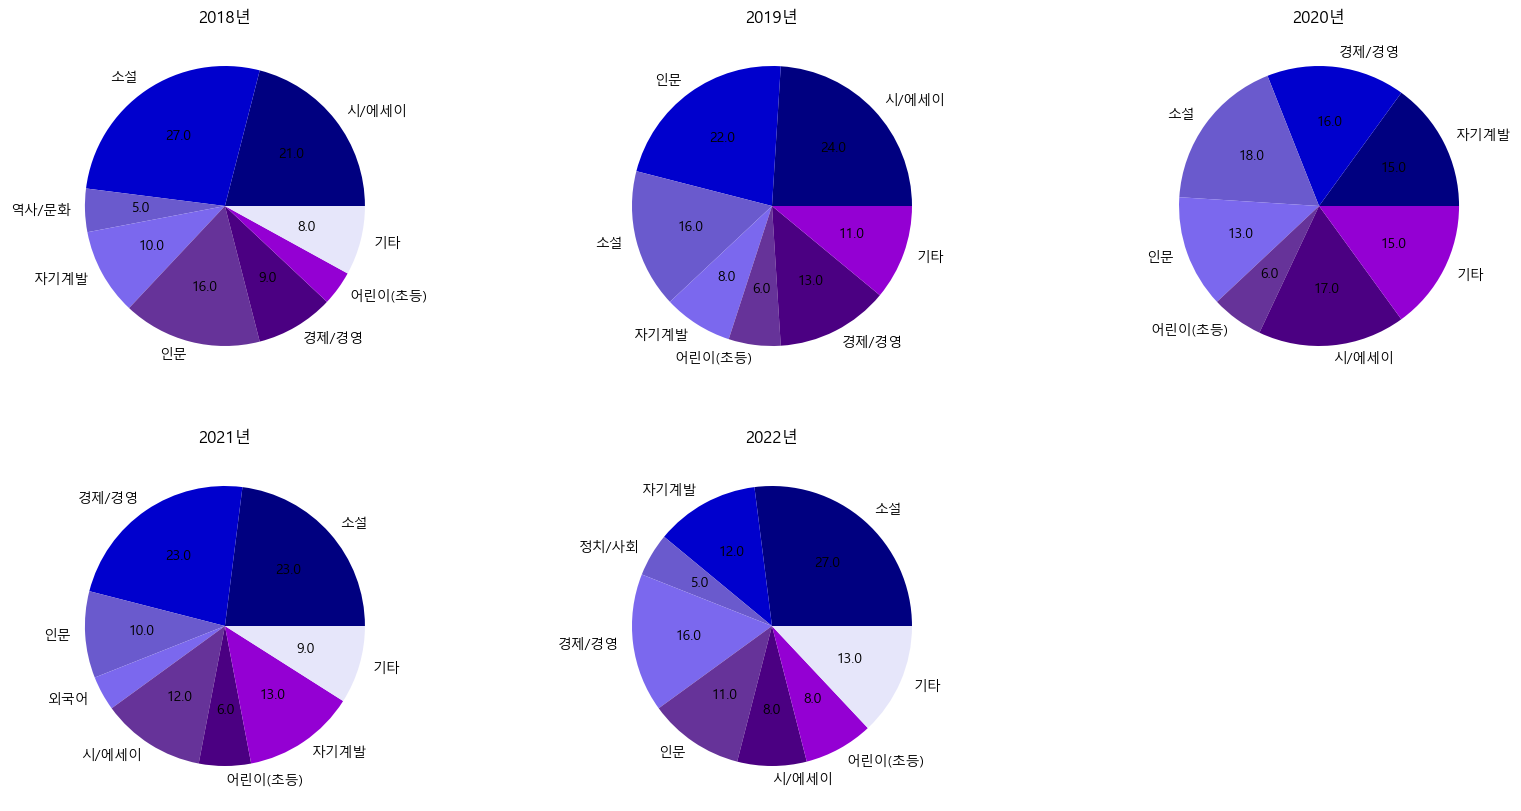

In [30]:
# 원그래프 연도별로 출력하기

plt.figure(figsize=(20,10))
colors = ['navy','mediumblue','slateblue','mediumslateblue','rebeccapurple','indigo','darkviolet','lavender']
# 2018년부터 2022년까지
years = [i for i in range(2018,2023)]
i = 1
for year in years:
    SQL = """with sub as (
        SELECT genre, count(*) c FROM best_books_5years
        WHERE years = {} GROUP BY genre)
    select * from  sub a where a.c > 3
    union
    select concat('기타') genre, sum(b.c) c from sub b where b.c <= 3;""".format(year)
    cursor.execute(SQL)
    res = cursor.fetchall()
    dict_res = dict((x,y)for x,y in res) # # tuple -> dictionary
    
    ratio = []
    labels = []
    for key, value in dict_res.items():
        labels.append(key)
        ratio.append(value)
    plt.subplot(2,3,i)
    i+=1
    plt.pie(ratio, labels=labels, autopct=(lambda x: str(round(x,0)) if x > 5 else ' '), colors=colors)
    plt.title('{}년'.format(year))
    
# 책이 3권 이하는 기타
plt.show()

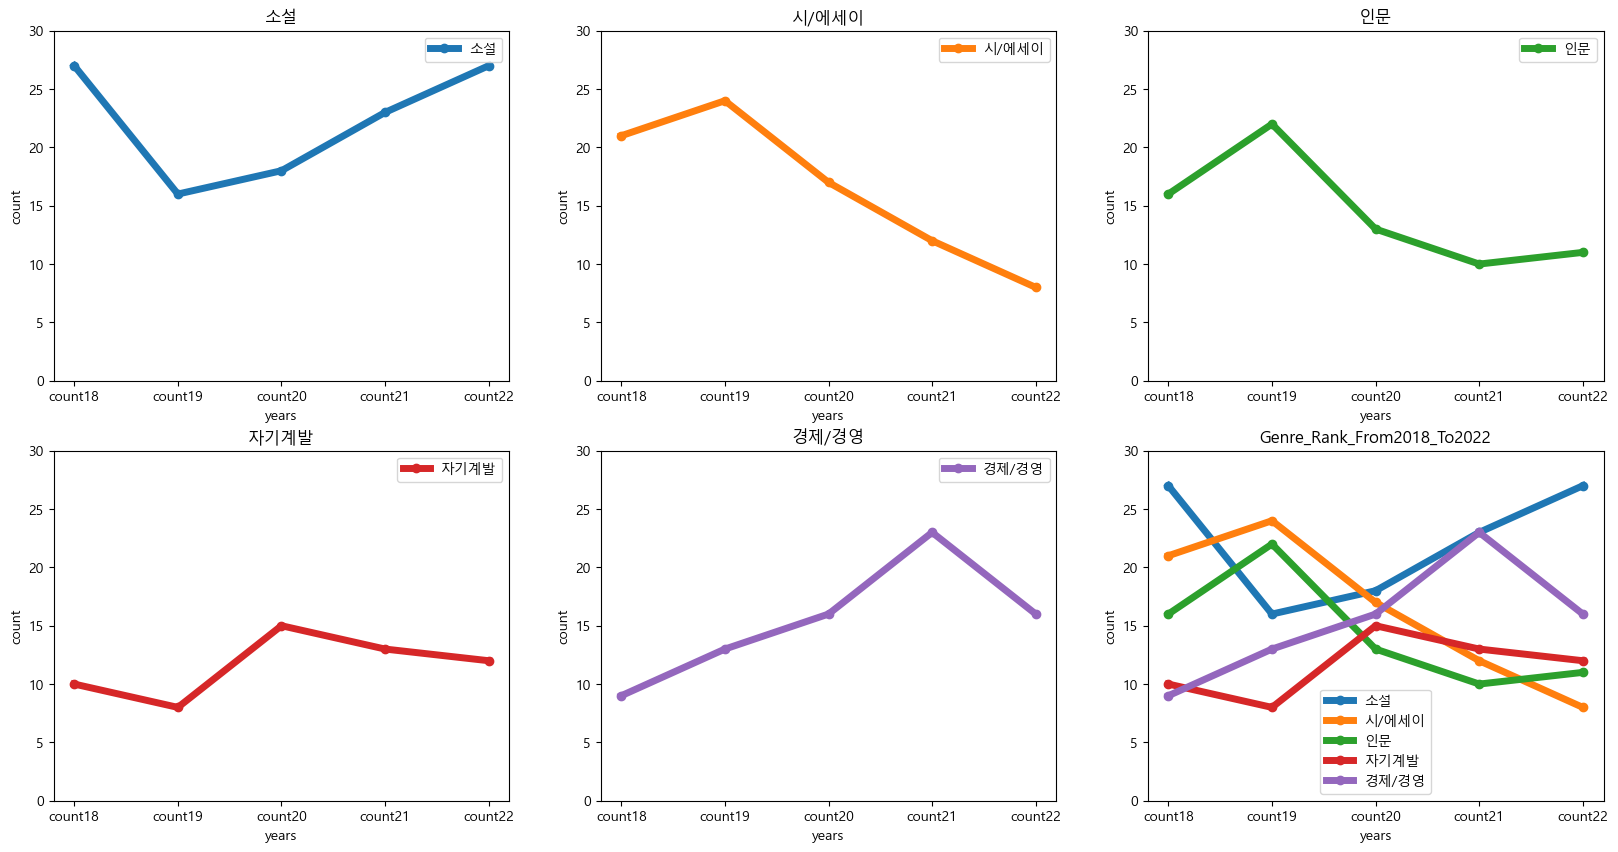

In [137]:
# '경제/경영','소설','시/에세이','인문','자기계발' 상위 5장르의 권 수 꺾은선 그래프

# 딕셔너리 형식으로 sql 분석쿼리 불러오기
cursor = db.cursor(pymysql.cursors.DictCursor) 
sql = """
SELECT g.genre, b18.g_count count18, b19.g_count count19, b20.g_count count20, 
       b21.g_count count21, b22.g_count count22
FROM genre_idx g LEFT JOIN book22 b22 ON g.genre = b22.genre
                 LEFT JOIN book21 b21 ON g.genre = b21.genre
                 LEFT JOIN book20 b20 ON g.genre = b20.genre
                 LEFT JOIN book19 b19 ON g.genre = b19.genre
                 LEFT JOIN book18 b18 ON g.genre = b18.genre
WHERE not(b22.g_count is null and b21.g_count is null and b20.g_count is null
      and b19.g_count is null and b18.g_count is null)
ORDER BY 2 DESC LIMIT 5;"""
cursor.execute(query=sql)
result = cursor.fetchall()

fig = plt.figure(figsize=(20,10))
fig.set_facecolor('white')

# 각 장르별 경향
x = list(result[0].keys()); y = []
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']
for i in range(len(result)):
    y.append(list(result[i].values()))
    plt.subplot(2,3,i+1)
    plt.plot(x[1:],y[-1][1:],marker='o',label=y[-1][0], linewidth='5',color=colors[i])
    plt.title(y[-1][0])
    plt.legend(); plt.ylim([0,30])
    plt.xlabel('years'); plt.ylabel('count')
    
# 종합
for i in range(len(result)):
    y.append(list(result[i].values()))
    plt.subplot(2,3,6)
    plt.plot(x[1:],y[-1][1:],marker='o',label=y[-1][0], linewidth='5')
    plt.title('Genre_Rank_From2018_To2022')
    plt.xlabel('years'); plt.ylabel('count')

plt.legend()
plt.ylim([0,30])
plt.show()

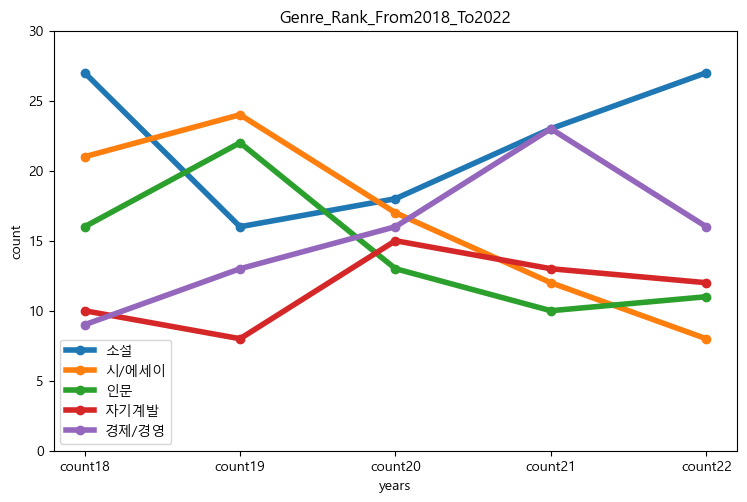

In [134]:
# 상위 5 장르 권 수 결과 확대
fig = plt.figure(figsize=(30,12))
fig.set_facecolor('white')
for i in range(len(result)):
    y.append(list(result[i].values()))
    plt.subplot(2,3,6)
    plt.plot(x[1:],y[-1][1:],marker='o',label=y[-1][0], linewidth='4')

plt.title('Genre_Rank_From2018_To2022')
plt.xlabel('years'); plt.ylabel('count')
plt.legend()
plt.ylim([0,30])
plt.show()

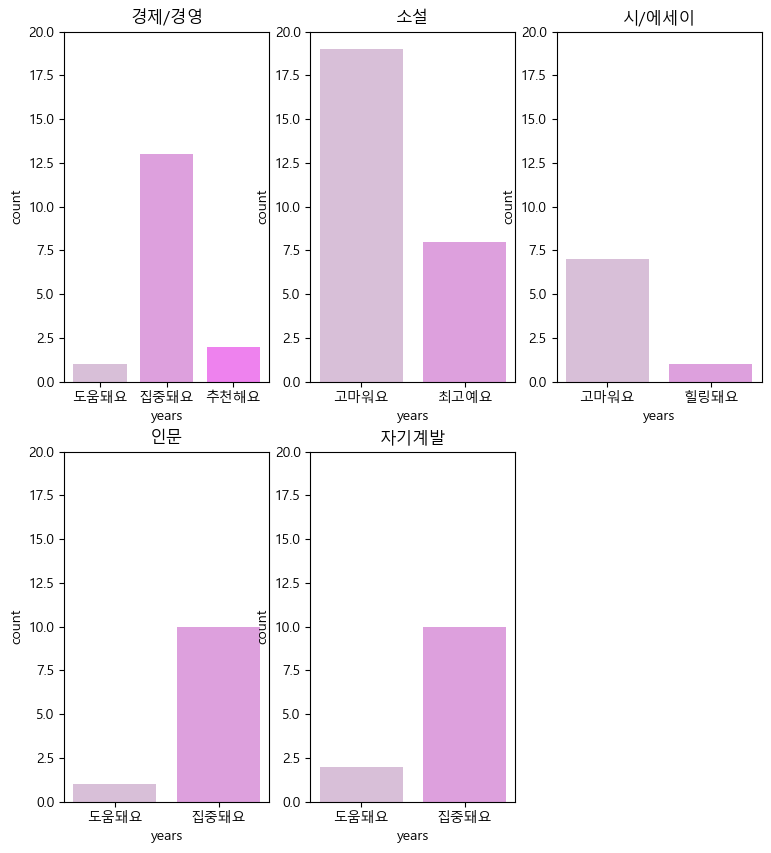

In [149]:
# 상위 5 장르 당 likes(코멘트) 경향성 막대그래프

sql = """SELECT genre, likes, count(likes) comment_n FROM best_books_5years
WHERE years = 2022 AND genre in ('소설','시/에세이','인문','자기계발','경제/경영')
GROUP BY genre, likes ORDER BY genre;"""

cursor.execute(query=sql)
result = cursor.fetchall() #result

genre_li = ['경제/경영','소설','시/에세이','인문','자기계발']
check = 0
data = [{},{},{},{},{}]
for i in range(len(result)):
    if result[i]['genre'] != genre_li[check]:
        check += 1
    data[check][result[i]['likes']] = result[i]['comment_n']

fig = plt.figure(figsize=(9,10))
for i in range(len(data)):
    plt.subplot(2,3,i+1)
    x = list(data[i].keys())
    values = list(data[i].values())
    plt.bar(x, values, color=['thistle','plum','violet'])
    plt.title(genre_li[i])
    plt.ylim([0,20])
    plt.xlabel('years'); plt.ylabel('count')
plt.show()

In [ ]:
db.commit()
db.close